In [117]:
from sqlalchemy import create_engine, text 
import pandas as pd 
import dbutils as db 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

## Domande sui dati
1. Determinare il gradimento medio per autore
2. Gradimento medio per autore (mostrando la distribuzione dei valori) 
3. Definire un profilo degli utenti sulla base del loro gradimento per il genere letterario, considerando sia il numero di voti sia il valore del voto.
4. Raggruppare gli utenti con simili profili di interessi per i generi letterari 
5. Preso un utente, suggerire un libro che non ha letto sulla base del gradimento per i vari libri da parte di utenti con il profilo simile
   
```
book(id, title, pages, author, rating_count, description)
rating(book, user, rating)
genre(book, genre)
```

In [51]:
engine = create_engine("sqlite:////Users/flint/Data/kaggle/books/book-recommender/booksdb.sql")

#### 1. Gradimento medio per autore

In [52]:
sql_1 = """
SELECT B.author, AVG(R.rating) AS avg_rating, COUNT(*) AS num_ratings
FROM rating AS R JOIN books AS B
ON R.book = B.id
GROUP BY B.author
""" 
sql_1bis = """
SELECT B.author, R.rating
FROM rating AS R JOIN books AS B
ON R.book = B.id
""" 

In [53]:
answer_1 = db.search(sql=sql_1, engine=engine)

In [54]:
answer_1.sort_values('avg_rating', ascending=False).head(2)

,author,avg_rating,num_ratings
6,Cassandra Clare,4.439496,119
61,R.J. Palacio,4.390110,182


In [55]:
answer_1.head(2)

,author,avg_rating,num_ratings
0,Abbi Glines,4.161078,167
1,Alex Flinn,3.540132,152


In [56]:
answer_1bis = db.search(sql=sql_1bis, engine=engine)

In [57]:
answer_1bis.groupby('author').agg(['mean', 'std'])

rating          
                         mean       std
author                                 
Abbi Glines          4.161078  0.762830
Alex Flinn           3.540132  0.649224
Art Spiegelman       4.238849  0.549771
Becca Fitzpatrick    3.889796  0.706303
Brandon Sanderson    4.362000  0.554828
...                       ...       ...
Tom Clancy           3.826119  0.729603
Tony Moore           4.210256  0.480012
Ursula K. Le Guin    3.795876  0.672312
Veronica Roth        3.991489  0.618298
William Shakespeare  4.165672  0.616577

[83 rows x 2 columns]

#### 2. Distribuzione dei valori di rating per autore

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

In [59]:
sql_2 = """
SELECT B.author, R.rating
FROM rating AS R JOIN books AS B
ON R.book = B.id
WHERE B.author in ('Douglas Adams', 'Markus Zusak')
""" 

In [60]:
answer_2 = db.search(sql=sql_2, engine=engine)

In [68]:
answer_2.head(2)

,author,rating
0,Douglas Adams,2.5
1,Douglas Adams,2.7


In [69]:
answer_2bis = db.search(sql_1, engine=engine)

In [70]:
answer_2bis.head(5)

,author,avg_rating,num_ratings
0,Abbi Glines,4.161078,167
1,Alex Flinn,3.540132,152
2,Art Spiegelman,4.238849,139
3,Becca Fitzpatrick,3.889796,98
4,Brandon Sanderson,4.362000,100


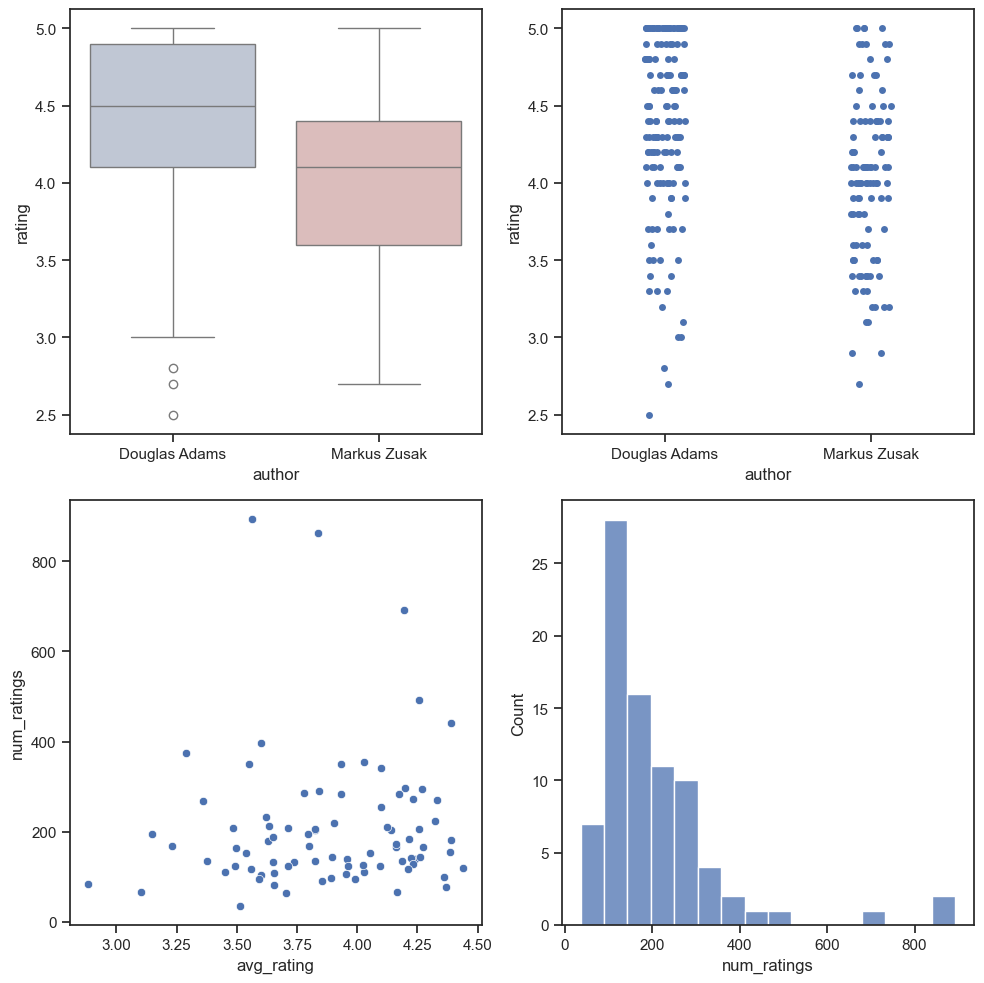

In [73]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)
sns.boxplot(answer_2, x='author', y='rating', 
            palette="vlag", hue='author', ax=ax[0, 0])
sns.stripplot(answer_2, ax=ax[0, 1], x='author', y='rating')
sns.scatterplot(answer_2bis, x='avg_rating', 
                y='num_ratings', ax=ax[1, 0])
sns.histplot(answer_2bis, x='num_ratings', ax=ax[1, 1])
plt.tight_layout()
plt.show()

#### 3. Definire un profilo degli utenti sulla base del loro gradimento per il genere letterario, considerando sia il numero di voti sia il valore del voto.
```
book(id, title, pages, author, rating_count, description)
rating(book, user, rating)
genre(book, genre)
```

In [86]:
sql_3 = """
SELECT R.user, G.genre, SUM(R.rating) AS score
FROM rating AS R JOIN genre AS G
ON R.book = G.book
GROUP BY R.user, G.genre
""" 

In [87]:
answer_3 = db.search(sql_3, engine=engine)

In [88]:
answer_3.head(10)

,user,genre,score
0,0,biography,10.5
1,0,children,2.8
2,0,comics,7.5
3,0,crime,5.8
4,0,fantasy,3.0
5,0,fiction,10.5
6,0,graphic,7.5
7,0,historical fiction,10.5
8,0,history,10.5
9,0,mystery,5.8


In [92]:
answer_3[answer_3.user == 4580]

,user,genre,score
7171,4580,children,4.0
7172,4580,crime,5.0
7173,4580,fantasy,9.0
7174,4580,fiction,9.0
7175,4580,mystery,5.0
7176,4580,paranormal,9.0
7177,4580,romance,9.0
7178,4580,thriller,5.0
7179,4580,young-adult,9.0


In [101]:
genre_list = list(answer_3.genre.unique())
user_list = list(answer_3.user.unique())
profile_matrix = np.zeros((len(user_list), len(genre_list)))

In [106]:
for i, row in answer_3.iterrows():
    u, s, g = row['user'], row['score'], row['genre']
    user_index = user_list.index(u)
    genre_index = genre_list.index(g)
    profile_matrix[user_index, genre_index] = s

**Scaling data**

In [119]:
scaler = MinMaxScaler()
profile_matrix = scaler.fit_transform(profile_matrix)
profile_matrix

array([[1.        , 0.18918919, 0.51724138, ..., 0.47933884, 0.55555556,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.26446281, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2010582 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2010582 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.26455026,
        0.        ]])

In [120]:
profile = pd.DataFrame(profile_matrix, 
                    index=user_list, columns=genre_list)

In [121]:
profile

,biography,children,comics,crime,fantasy,fiction,graphic,historical fiction,history,mystery,non-fiction,paranormal,romance,thriller,young-adult,poetry
0,1.0,0.189189,0.517241,0.479339,0.172414,0.555556,0.517241,1.0,1.0,0.479339,0.581395,0.172414,0.158730,0.479339,0.555556,0.0
1,0.0,0.000000,0.000000,0.264463,0.000000,0.169312,0.000000,0.0,0.0,0.264463,0.000000,0.000000,0.000000,0.264463,0.000000,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.201058,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.201058,0.000000,0.201058,0.0
4,0.0,0.000000,0.000000,0.000000,0.189655,0.174603,0.000000,0.0,0.0,0.000000,0.000000,0.189655,0.174603,0.000000,0.000000,0.0
7,0.0,0.297297,0.000000,0.000000,0.252874,0.232804,0.000000,0.0,0.0,0.000000,0.000000,0.252874,0.232804,0.000000,0.232804,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83971,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0
84075,0.0,0.000000,0.000000,0.000000,0.241379,0.222222,0.000000,0.0,0.0,0.000000,0.000000,0.241379,0.000000,0.000000,0.222222,0.0
84107,0.0,0.000000,0.000000,0.000000,0.000000,0.089947,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.089947,0.000000,0.000000,0.0
84228,0.0,0.000000,0.000000,0.000000,0.000000,0.201058,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.201058,0.000000,0.201058,0.0


In [122]:
profile_matrix[0]

array([1.        , 0.18918919, 0.51724138, 0.47933884, 0.17241379,
       0.55555556, 0.51724138, 1.        , 1.        , 0.47933884,
       0.58139535, 0.17241379, 0.15873016, 0.47933884, 0.55555556,
       0.        ])

In [123]:
profile_matrix[1]

array([0.        , 0.        , 0.        , 0.26446281, 0.        ,
       0.16931217, 0.        , 0.        , 0.        , 0.26446281,
       0.        , 0.        , 0.        , 0.26446281, 0.        ,
       0.        ])

**User similarity**

In [124]:
from sklearn.metrics import pairwise_distances

In [125]:
sigma = pairwise_distances(profile_matrix, profile_matrix)

In [128]:
S = pd.DataFrame(sigma, index=user_list, columns=user_list)

In [134]:
S.loc[0].sort_values(ascending=False)

27010    2.491241
588      2.450653
2985     2.388332
24788    2.361610
12530    2.358428
           ...   
28026    0.599122
65668    0.556369
37050    0.549468
60109    0.525742
0        0.000000
Name: 0, Length: 15039, dtype: float64

In [132]:
answer_3[answer_3.user == 0]

,user,genre,score
0,0,biography,10.5
1,0,children,2.8
2,0,comics,7.5
3,0,crime,5.8
4,0,fantasy,3.0
5,0,fiction,10.5
6,0,graphic,7.5
7,0,historical fiction,10.5
8,0,history,10.5
9,0,mystery,5.8


In [135]:
answer_3[answer_3.user == 27010]

,user,genre,score
38283,27010,children,14.6
38284,27010,fantasy,14.6
38285,27010,fiction,14.6
38286,27010,paranormal,14.6
38287,27010,young-adult,14.6
